<a href="https://colab.research.google.com/github/fjadidi2001/DataScienceJourney/blob/master/PINNs_S4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import necessary libraries


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# For handling differential equations
from scipy.integrate import odeint


# Generate the dataset


In [ ]:
# Generate synthetic data for the heat equation u_t = alpha * u_xx
alpha = 0.01  # Thermal diffusivity

# Define the domain
x = np.linspace(0, 1, 100)
t = np.linspace(0, 1, 100)
X, T = np.meshgrid(x, t)

# Define the initial condition u(x, 0) = sin(pi * x)
U0 = np.sin(np.pi * x)

# Define a function that represents the solution u(x, t)
def heat_eqn(U0, t, alpha):
    def model(U, t):
        Ux = np.gradient(U, x)
        Uxx = np.gradient(Ux, x)
        return alpha * Uxx
    return odeint(model, U0, t)

# Generate data
U = heat_eqn(U0, t, alpha)

# Flatten the meshgrid arrays for the PINN input
X_train = np.vstack([X.ravel(), T.ravel()]).T
U_train = U.ravel()


# Define the PINN Architecture


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Define the neural network model using TensorFlow/Keras
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(20, activation='tanh', input_shape=(2,)),
        tf.keras.layers.Dense(20, activation='tanh'),
        tf.keras.layers.Dense(20, activation='tanh'),
        tf.keras.layers.Dense(1, activation=None)
    ])
    return model

model = create_model()

# Define the Loss Function

In [ ]:
def physics_informed_loss(model, X_train, U_train, alpha):
    # Ensure inputs are float32
    X_train = tf.cast(X_train, dtype=tf.float32)
    U_train = tf.cast(U_train, dtype=tf.float32)
    alpha = tf.cast(alpha, dtype=tf.float32)

    x = X_train[:, 0:1]
    t = X_train[:, 1:2]

    # Forward pass to compute u(x, t)
    with tf.GradientTape(persistent=True) as tape1:
        tape1.watch([x, t])
        u_pred = model(tf.concat([x, t], axis=1))
        u_pred = tf.cast(u_pred, dtype=tf.float32)  # Ensure prediction is float32
        u_x = tape1.gradient(u_pred, x)

    with tf.GradientTape(persistent=True) as tape2:
        tape2.watch(t)
        u_t = tape2.gradient(u_pred, t)

    u_xx = tape1.gradient(u_x, x)

    # Clean up tapes
    del tape1
    del tape2

    # Debugging: Check if gradients are None
    if u_x is None:
        raise ValueError("Gradient u_x is None")
    if u_t is None:
        raise ValueError("Gradient u_t is None")
    if u_xx is None:
        raise ValueError("Gradient u_xx is None")

    # Physics loss (PDE residual)
    physics_loss = tf.reduce_mean(tf.square(u_t - alpha * u_xx))

    # Data loss
    data_loss = tf.reduce_mean(tf.square(u_pred - U_train))

    # Total loss
    total_loss = data_loss + physics_loss
    return total_loss

# Ensure the model input is float32
X_train = tf.cast(X_train, dtype=tf.float32)
U_train = tf.cast(U_train, dtype=tf.float32)

# Training loop remains the same


#  Compile and Train the Model

In [ ]:
optimizer = tf.keras.optimizers.Adam()

@tf.function
def train_step(X_train, U_train):
    with tf.GradientTape() as tape:
        loss = physics_informed_loss(model, X_train, U_train, alpha)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

# Training loop
epochs = 1000
for epoch in range(epochs):
    loss = train_step(X_train, U_train)
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.numpy()}')


ValueError: in user code:

    File "<ipython-input-7-191499527ec4>", line 6, in train_step  *
        loss = physics_informed_loss(model, X_train, U_train, alpha)
    File "<ipython-input-21-0d0916c2a850>", line 31, in physics_informed_loss  *
        raise ValueError("Gradient u_t is None")

    ValueError: Gradient u_t is None


In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load and preprocess the data
housing = fetch_california_housing()
X, y = housing.data, housing.target

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Neural network model
class SimpleModel(keras.Model):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.hidden1 = keras.layers.Dense(64, activation='relu')
        self.hidden2 = keras.layers.Dense(32, activation='relu')
        self.output_layer = keras.layers.Dense(1)

    def call(self, inputs):
        x = self.hidden1(inputs)
        x = self.hidden2(x)
        return self.output_layer(x)

# Instantiate the model
model = SimpleModel()

# Define the loss function
mse_loss = tf.keras.losses.MeanSquaredError()

# Small epsilon to avoid division by zero
epsilon = 1e-8

# Custom training step
@tf.function
def train_step(inputs, targets):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = mse_loss(targets, predictions)

        # Physics-informed regularization
        sorted_indices = tf.argsort(inputs[:, 0])  # Assuming the 1st feature correlates with price
        sorted_predictions = tf.gather(predictions, sorted_indices)
        area_diff = tf.experimental.numpy.diff(sorted_predictions[:, 0]) / (tf.experimental.numpy.diff(tf.gather(inputs[:, 0], sorted_indices)) + epsilon)
        area_effect = -tf.reduce_mean(area_diff)
        loss += 0.1 * tf.nn.relu(-area_effect)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

# Initialize the optimizer with a lower learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Training loop
num_epochs = 1000
batch_size = 32
for epoch in range(num_epochs):
    for i in range(0, len(X_train), batch_size):
        batch_inputs = X_train[i:i+batch_size]
        batch_targets = y_train[i:i+batch_size]
        loss = train_step(tf.convert_to_tensor(batch_inputs, dtype=tf.float32),
                          tf.convert_to_tensor(batch_targets, dtype=tf.float32))

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss:.4f}')

# Evaluate the model
test_predictions = model(tf.convert_to_tensor(X_test, dtype=tf.float32))
test_loss = mse_loss(y_test, test_predictions)
print(f'Test Loss: {test_loss:.4f}')


Epoch [100/1000], Loss: nan
Epoch [200/1000], Loss: nan
Epoch [300/1000], Loss: nan
Epoch [400/1000], Loss: nan
Epoch [500/1000], Loss: nan
Epoch [600/1000], Loss: nan
Epoch [700/1000], Loss: nan
Epoch [800/1000], Loss: nan
Epoch [900/1000], Loss: nan
Epoch [1000/1000], Loss: nan
Test Loss: nan


In [31]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt


In [32]:
# Load the dataset
california = fetch_california_housing()

# Convert to DataFrame for better visualization
df = pd.DataFrame(california.data, columns=california.feature_names)
df['Target'] = california.target

df.head()


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [33]:
# Split the data into features (X) and target (y)
X = df.drop('Target', axis=1)
y = df['Target']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [34]:
# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [35]:
# Create the model
model = models.Sequential()

# Add layers
model.add(layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])


In [36]:
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_17 (Dense)                     │ (None, 64)                  │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,801 (18.75 KB)

 Trainable params: 4,801 (18.75 KB)

 Non-trainable params: 0 (0.00 B)

In [37]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2, batch_size=32)


Epoch 1/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1.6933 - mae: 0.8996 - val_loss: 0.4718 - val_mae: 0.4966
Epoch 2/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4266 - mae: 0.4608 - val_loss: 0.4083 - val_mae: 0.4475
Epoch 3/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3680 - mae: 0.4296 - val_loss: 0.3857 - val_mae: 0.4357
Epoch 4/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3538 - mae: 0.4216 - val_loss: 0.3924 - val_mae: 0.4224
Epoch 5/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3528 - mae: 0.4139 - val_loss: 0.3483 - val_mae: 0.4107
Epoch 6/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3330 - mae: 0.4033 - val_loss: 0.3397 - val_mae: 0.4149
Epoch 7/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3161 - mae: 0.3904 - val_loss: 0.3312 - val_mae: 0.4048
Epoch 8/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2999 - mae: 0.3845 - val_loss: 0.3226 - val_mae: 0.3866
Epoch 9/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - lo

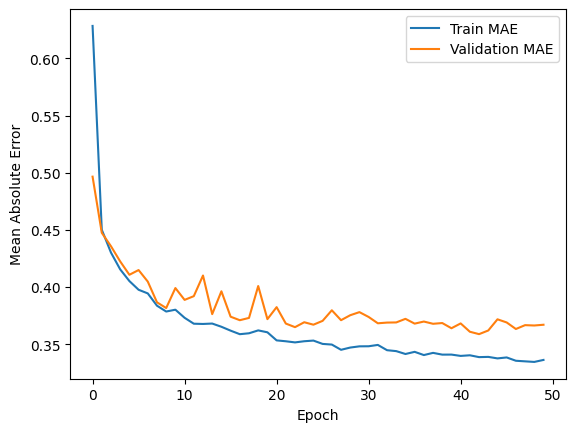

In [38]:
# Plot training history
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()


Certainly! Let's walk through implementing a Physics-Informed Neural Network (PINN) step by step. I'll explain each part of the process, including data preprocessing, model creation, training, and evaluation, in simple terms.

### What is a PINN?

A Physics-Informed Neural Network (PINN) is a type of neural network that incorporates physical laws (expressed as differential equations) into the training process. This helps the model to better understand and predict physical phenomena. However, for simplicity, we'll use a standard dataset (like the California housing dataset) to demonstrate the principles of neural networks first, then explain how physics can be integrated later.

### Step 1: Load and Preprocess the Dataset

We'll start by loading the California Housing dataset, which is a popular dataset for predicting house prices based on various features like the number of rooms, population, etc.

#### 1.1. Importing Libraries

First, we'll import the necessary libraries.

```python
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
```

- **Numpy & Pandas:** For handling numerical data and data frames.
- **Scikit-learn:** For loading datasets, splitting them into training and testing sets, and scaling (normalizing) the data.
- **TensorFlow & Keras:** For building and training the neural network model.
- **Matplotlib:** For visualization.

#### 1.2. Loading the Dataset

Next, we'll load the California housing dataset.

```python
# Load the dataset
california = fetch_california_housing()

# Convert to DataFrame for better visualization
df = pd.DataFrame(california.data, columns=california.feature_names)
df['Target'] = california.target

df.head()
```

- **Goal:** We are loading the dataset and converting it into a Pandas DataFrame for easier manipulation and visualization.

#### 1.3. Splitting the Dataset

We need to split the dataset into training and testing sets. The training set is used to train the model, while the test set is used to evaluate its performance.

```python
# Split the data into features (X) and target (y)
X = df.drop('Target', axis=1)
y = df['Target']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
```

- **Goal:** We are splitting the data into two sets: one for training (80% of the data) and one for testing (20% of the data).

#### 1.4. Data Preprocessing

Neural networks work better when the data is scaled. We'll scale the features using `StandardScaler`.

```python
# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
```

- **Goal:** We are normalizing the data to ensure all features have a mean of 0 and a standard deviation of 1. This helps the neural network learn better.

### Step 2: Creating the Neural Network Model

Now, let's create a simple neural network model using TensorFlow and Keras.

#### 2.1. Building the Model

We'll define a simple feedforward neural network with a few hidden layers.

```python
# Create the model
model = models.Sequential()

# Add layers
model.add(layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
```

- **Goal:**
  - We start by creating a Sequential model.
  - We add two hidden layers with 64 neurons each and ReLU activation functions.
  - Finally, we add an output layer with one neuron (since we're predicting a single value).
  - We compile the model using the Adam optimizer, mean squared error (MSE) as the loss function, and mean absolute error (MAE) as a metric to monitor.

#### 2.2. Visualizing the Model Architecture

Let's visualize the model to better understand its structure.

```python
model.summary()
```

- **Goal:** We print the summary of the model, which shows the architecture of the neural network, including the number of layers and parameters.

### Step 3: Training the Model

Now, let's train the model using the training data.

```python
# Train the model
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2, batch_size=32)
```

- **Goal:**
  - We train the model for 50 epochs. An epoch is one complete pass through the training data.
  - We also reserve 20% of the training data for validation to monitor the model's performance during training.
  - The `history` object will store the loss and metrics for each epoch, which we can visualize later.

### Step 4: Evaluating the Model

After training, we evaluate the model using the test data.

```python
# Evaluate the model on test data
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test MAE: {test_mae}")
```

- **Goal:** We evaluate the model's performance on the test set and print the mean absolute error (MAE) as a metric.

### Step 5: Visualizing the Results

Finally, let's visualize the training process and the model's predictions.

#### 5.1. Plotting Training History

We can plot the training and validation loss over epochs to see how the model learned over time.

```python
# Plot training history
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()
```

- **Goal:** We are plotting the mean absolute error for both the training and validation sets across each epoch. This helps us see if the model is improving over time.

#### 5.2. Plotting Predictions vs. Actual Values

Let's compare the model's predictions with the actual values.

```python
# Predict on test data
y_pred = model.predict(X_test)

# Scatter plot of actual vs predicted values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()
```

- **Goal:** We scatter plot the predicted values against the actual values to visualize how well the model is performing.

### Summary

- **Data Preparation:** We loaded the California Housing dataset, split it into training and test sets, and scaled the features.
- **Model Creation:** We built a simple feedforward neural network with two hidden layers.
- **Training:** We trained the model for 50 epochs and monitored its performance using validation data.
- **Evaluation:** We evaluated the model on the test set and visualized the results to understand its performance.

This is a basic introduction to neural networks using the California Housing dataset. If you want to go deeper into PINNs, we can discuss how to incorporate physical laws into the training process!